# Exper3
我们很好奇为什么 DDIM 能够在更少的步数内生成高质量图片，为此我们可以进行一个实验进行探索。

通过推导可以得出关于**贝叶斯最优模型**而言， $\hat x_0 = \mathbb E_{x_0\sim \phi(x_0,x_t)}\left[ x_0\right]$ 且 $\frac{x_{t-1}}{\sqrt{1-\bar \alpha_{t-1}}} = \frac{x_t}{\sqrt{1-\bar \alpha_{t}}} + \left( \frac{\sqrt{\bar \alpha_{t-1}}}{\sqrt{1-\bar \alpha_{t-1}}}-\frac{\sqrt{\bar \alpha_{t}}}{\sqrt{1-\bar \alpha_{t}}}\right)\cdot \hat x_0$  
于是我们可以设置 $q(x_0) = \mathcal N(3, I)$，这样每次迭代的 $\hat x_0$ 有解析式，可以实现迭代的可视化。

In [2]:
import numpy as np
from tqdm import tqdm

In [3]:
# alpha sequence
T = 1000  
beta_start = 1e-4
beta_end = 0.02

betas = np.linspace(beta_start, beta_end, T, dtype=np.float64)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)

sigma_list = [
    np.sqrt(((1 - alpha_bars[t-1]) / (1 - alpha_bars[t])) * betas[t])
    for t in range(1, T)
]
# sigma_list = [np.sqrt(1-alpha_bar) for alpha_bar in alpha_bars]

## 1 Dim
为了方便推导，我们先考虑一维的情况，此时可以推导出 $\hat x_0 =   2\frac{1}{\sqrt{2\pi}}\sqrt{1-\bar\alpha_t} +\sqrt{\bar \alpha_t }\cdot x_t + 3(1-\bar \alpha_t)$

In [8]:
def ddim_update(x_t, x0_pred, epsilon, alpha_bar_t, alpha_bar_prev, sigma_prev):
    
    coef1 = np.sqrt(max(0, 1 - alpha_bar_prev - sigma_prev**2)) / np.sqrt(1 - alpha_bar_t)
    coef2 = np.sqrt(alpha_bar_prev) - coef1 * np.sqrt(alpha_bar_t)
    coef3 = sigma_prev

    x_prev = coef1 * x_t + coef2 * x0_pred + coef3 * epsilon
    return x_prev, coef1, coef2, coef3

def ddim_loop(sigma_list, t=50, begin=-10):
    x_t = begin
    timesteps = np.linspace(998, 1, t, dtype=int)
    x_list = []
    x_0_list = []
    c1_list, c2_list, c3_list = [], [], []

    for index in tqdm(range(len(timesteps)-1), desc="Timesteps"):
        
        step = timesteps[index]
        step_prev = timesteps[index+1]
        
        alpha_bar_t = alpha_bars[step]
        alpha_bar_prev = alpha_bars[step_prev]
        sigma_prev = sigma_list[step]
        
        x_0_hat = 2/np.sqrt(2*np.pi)*np.sqrt(1-alpha_bar_t)+np.sqrt(alpha_bar_t)*x_t+3*(1-alpha_bar_t)
        epsilon = np.random.normal(0, 1, 1)
        
        x_list.append(x_t)
        x_0_list.append(x_0_hat)
        
        x_t, c1, c2, c3 = ddim_update(x_t, x_0_hat, epsilon, alpha_bar_t, alpha_bar_prev, sigma_prev)
        
        c1_list.append(c1)
        c2_list.append(c2)
        c3_list.append(c3)
        

    return x_list, x_0_list, c1_list, c2_list, c3_list


In [23]:
t = 100
begin = 10
# DDIM
ddim_x_list, ddim_x_0_list, c1_list, c2_list, c3_list = ddim_loop([0]*(T-1), t, begin)

# DDPM
ddpm_x_list, ddpm_x_0_list, _, _, _ = ddim_loop(sigma_list, t, begin)

Timesteps: 100%|██████████| 99/99 [00:00<00:00, 31656.33it/s]


## Visualize
首先观察系数的变化趋势

In [ ]:
# c1_list[:10]
# l = c1_list + c2_list
# c1_list[:10]
# c2_list[:10]
# ddim_x_list[:10]

# print(ddim_x_list[0]*c1_list[0]) 
# print(ddim_x_0_list[0]*c2_list[0])
# print(c1_list[0]+c2_list[0])
# print(c1_list[0], c2_list[0])

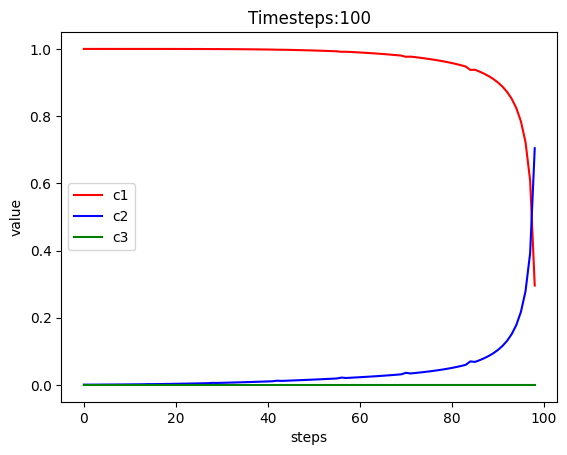

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(c1_list)), c1_list, color='red', label="c1")
plt.plot(range(len(c2_list)), c2_list, color='blue', label="c2")
plt.plot(range(len(c3_list)), c3_list, color='green', label="c3")
plt.title(f"Timesteps:{t}")
plt.xlabel("steps")
plt.ylabel("value")
plt.legend()


plt.show()

接着绘制出 $x_t$ 和 $\hat x_0$ 的曲线

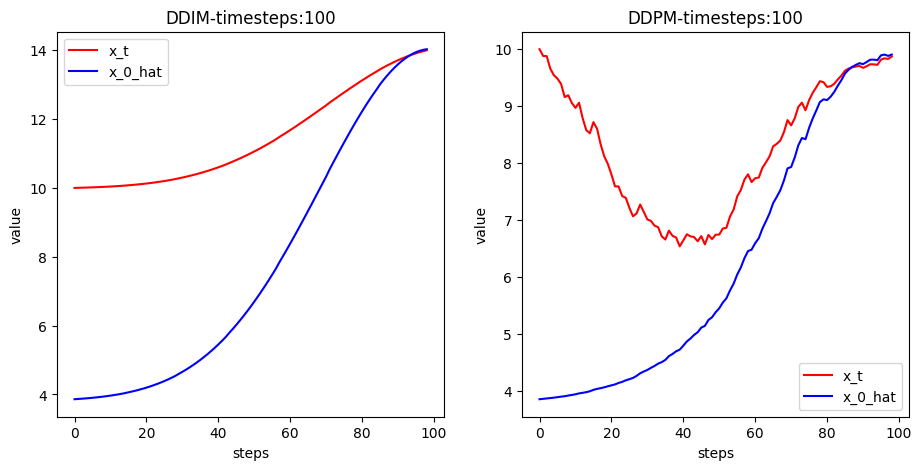

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(ddim_x_list)), ddim_x_list, color='red', label="x_t")
plt.plot(range(len(ddim_x_0_list)), ddim_x_0_list, color='blue', label="x_0_hat")
plt.title(f"DDIM-timesteps:{t}")
plt.xlabel("steps")
plt.ylabel("value")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(ddpm_x_list)), ddpm_x_list, color='red', label="x_t")
plt.plot(range(len(ddpm_x_0_list)), ddpm_x_0_list, color='blue', label="x_0_hat")
plt.title(f"DDPM-timesteps:{t}")
plt.xlabel("steps")
plt.ylabel("value")
plt.legend()


plt.show()